# Component inference and model families 

This notebook shows a series of examples of how to use model families and component inference with PCM.

In [10]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Simple 3 x 2 Anova
A classical example is a fully crossed design with two factors (A and B) and the possibility for an interaction between those two factors. 

#### Building a model family

In [11]:
# Generate the three model components, each one as a fixed model
M = []
A = np.array([[1.0,0,0],[1,0,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]])
B = np.array([[1.0,0],[0,1],[1,0],[0,1],[1,0],[0,1]])
M.append(pcm.FixedModel('A',A@A.T))
M.append(pcm.FixedModel('B',B@B.T))
M.append(pcm.FixedModel('I',np.eye(6)))
# Then construct a model family of all possible combinations 
MF=pcm.model.ModelFamily(M)

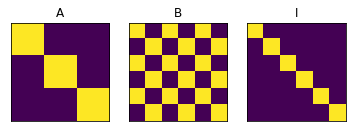

In [12]:
# Show the three model components
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(M[i].G)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(M[i].name)

Note that no effort was made here to remove any of the overlap between the categories. That is, the interaction can explain all possible differences between stimuli, also differences that could be attributed to A and B. 

#### Generating data 

In [13]:
# Now generate 20 data set from the full model 
trueModel = MF[-1]
[cond_vec,part_vec]=pcm.sim.make_design(6,8)
D = pcm.sim.make_dataset(trueModel,np.array([-1.0,-1.0,-1.0]),
        signal=0.1,
        n_sim = 20,
        n_channel=20,part_vec=part_vec,
        cond_vec=cond_vec)
    

#### Fitting the data 
Now we can fit the data with the entire model family. An intercept is added as a fixed effect for each partition (block) seperately, as common for fMRI data. The result is a likelihood for each of the model combination. 

<AxesSubplot:xlabel='model', ylabel='Log Bayes Factor'>

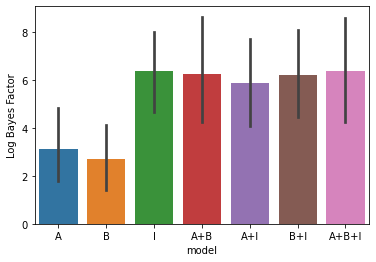

In [14]:
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block', fit_scale=False)
# Here we correcting for the number of parameters (using AIC)
pcm.vis.model_plot(T.likelihood-MF.num_comp_per_m)

#### Inference: Model posterior
For the inference, we can use either crossvalidated pseudo-likelihoods (within- subject or between subjects - see inference), or we can use the fitted likelihood, correcting for the number of paramaters using an AIC approach. We use latter approach here. 

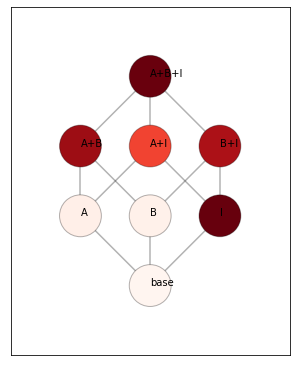

In [15]:
# We can computer the posterior probability of each of the mixture models. 
# This uses the flat prior over all possible model combinations 
# The whole model family can visualized as a model tree.  
plt.figure(figsize=(5,7))
# Get the mean likelihood 

mposterior = MF.model_posterior(T.likelihood.mean(axis=0),method='AIC',format='DataFrame')
pcm.vis.plot_tree(MF,mposterior,show_labels=True,show_edges=True)
# mposterior.to_numpy()

#### Inference: Component posterior
We can also get the posterior probability for each component. This is simply the sum of the posterior probabilties of all the model combinations that contain that component. The 0.5 line (this is the prior probability) is drawn. The lower line is the most evidence we can get for the absence of a model component using AIC. This is because, in the worst case, a new component does not increase the likelihood at all. This would result in the new component having a realtive likelihood that is 1.0 lower than the simpler model (parameter penality). Thus, overall the worst we can get p=1/(1+exp(1)).

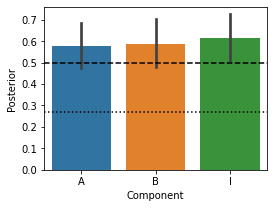

In [16]:

# Component posterior
plt.figure(figsize=(4,3))
cposterior = MF.component_posterior(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(cposterior,type='posterior')


#### Component Bayes factor 
For frequentist statistical testing and display, it is also often useful use the log-odds of the posterior $log(p/(1-p))$. For a flat prior across the model family, this is the bayes factor for the specific component. 

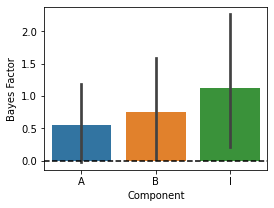

In [17]:
# Component Bayes Factor 
plt.figure(figsize=(4,3))
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')